YouTube per-CPU CGroup residency analysis (with new fbt changes)
=======================
This is a run of experiments/run_youtube.py with the cgroups module enabled.
This notebook parses and plots the trace.html

Following are the additional commits included:
```
b1d860bc1222 (HEAD) eas tprints
17023f8cc8fc sched/fair: run eas sync only if cpu about to idle
3e20aa321989 sched/fair: increase chances to use energy_diff
ca40b21b8554 events: add tracepoint for find_best_target
c62979a17401 sched/fair: streamline find_best_target heuristics
6755077a1cde build touch screen in
```

In [1]:
#!/usr/bin/env python
%pylab inline
import trappy
from trace import Trace
import logging
import pandas as pd
import numpy as np
import os

from conf import LisaLogging
LisaLogging.setup(level=logging.ERROR)
logging.info('#### Setup FTrace')
path_to_html = "/home/joelaf/repo/lisa-aosp/external/lisa/results/YouTube_eas_fbt_4.4.56-g931b784e1a3f-29952-gb1d860bc1222_trial2/trace.html"

Populating the interactive namespace from numpy and matplotlib


In [2]:
tr = Trace(None, path_to_html,
           cgroup_info = { 
               'cgroups': ['foreground', 'background', 'system-background', 'top-app', 'rt'],
               'controller_ids': { 4: 'cpuset', 2: 'schedtune' }
           },
           events=[ 'sched_switch', 'cgroup_attach_task_devlib', 'cgroup_attach_task', 'sched_process_fork' ],
           normalize_time=False)

Total amount of time spent per Cgroup (schedtune)
===========================
(NaN is the idle task)

In [3]:
tr.data_frame.cpu_residencies_cgroup('schedtune')

,cpu_0,cpu_1,cpu_2,cpu_3,cpu_4,cpu_5,cpu_6,cpu_7,total
schedtune,,,,,,,,,
background,0.078974,0.952785,0.011557,0.008316,0.000000,0.000000,0.186345,0.533103,1.771080
foreground,3.405653,3.143571,1.418475,0.896985,0.662223,0.166403,0.241597,0.317459,10.252366
root,5.070404,3.199380,3.641579,2.610207,0.280362,0.144083,0.971765,0.331811,16.249591
top-app,0.430083,0.273317,0.131131,0.091833,4.176073,2.836142,1.130956,0.297066,9.366601
NaN,23.383548,25.605660,27.159864,28.756723,27.244724,29.208070,29.829145,30.881370,222.069104


Plot per-CPU breakdown without considering idle time
------------------------------------------------------------

/home/joelaf/anaconda2/lib/python2.7/site-packages/matplotlib/__init__.py:938: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


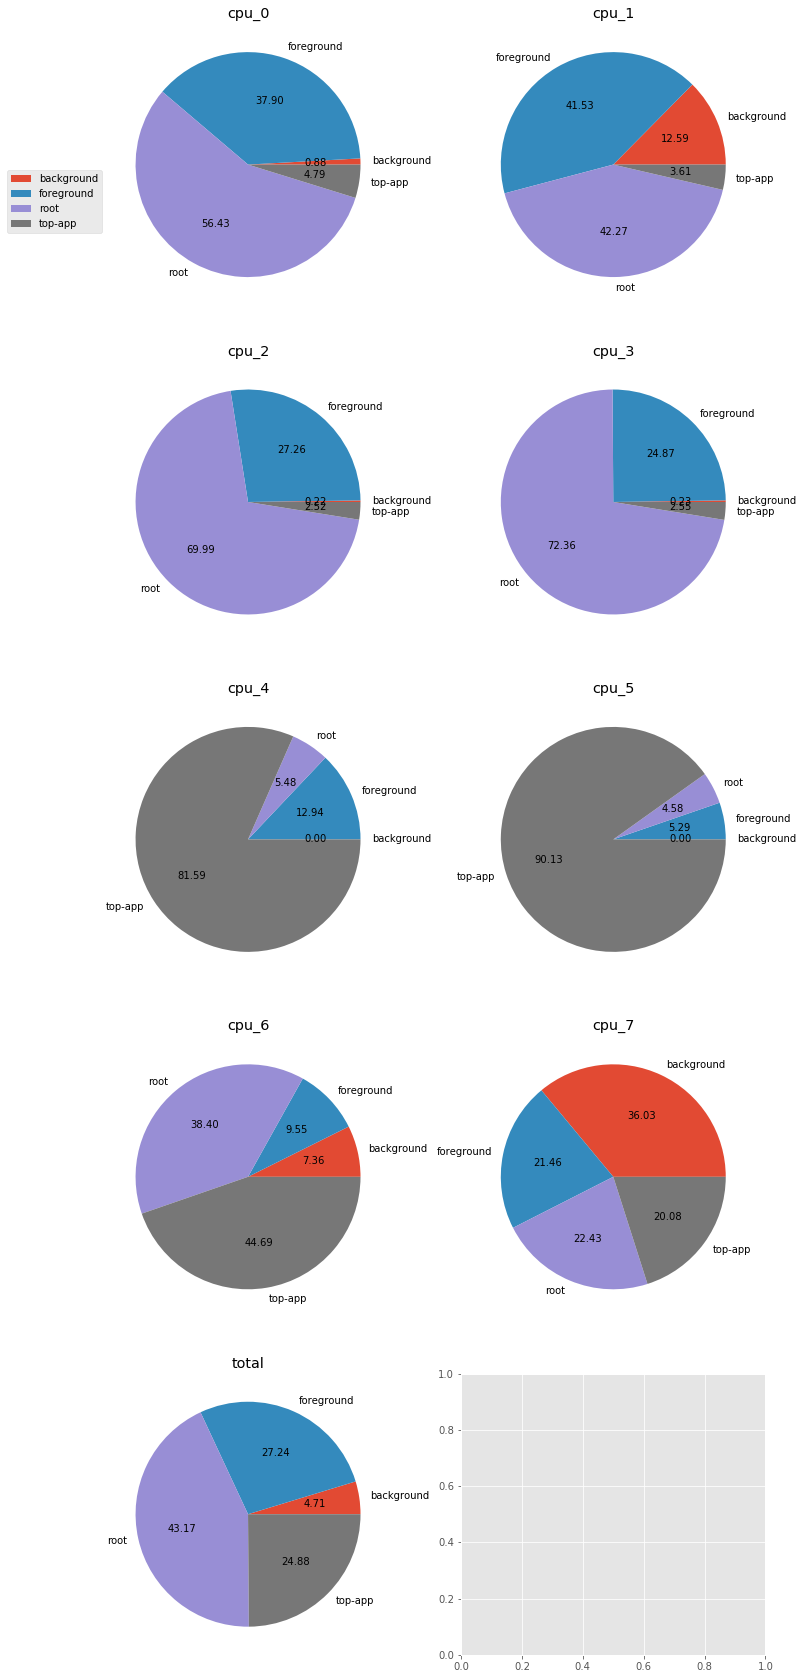

In [4]:
tr.analysis.residency.plot_cgroup('schedtune', idle=False)

Plot per-CPU breakdown WITH considering idle time (yellow slice)
------------------------------------------------------------

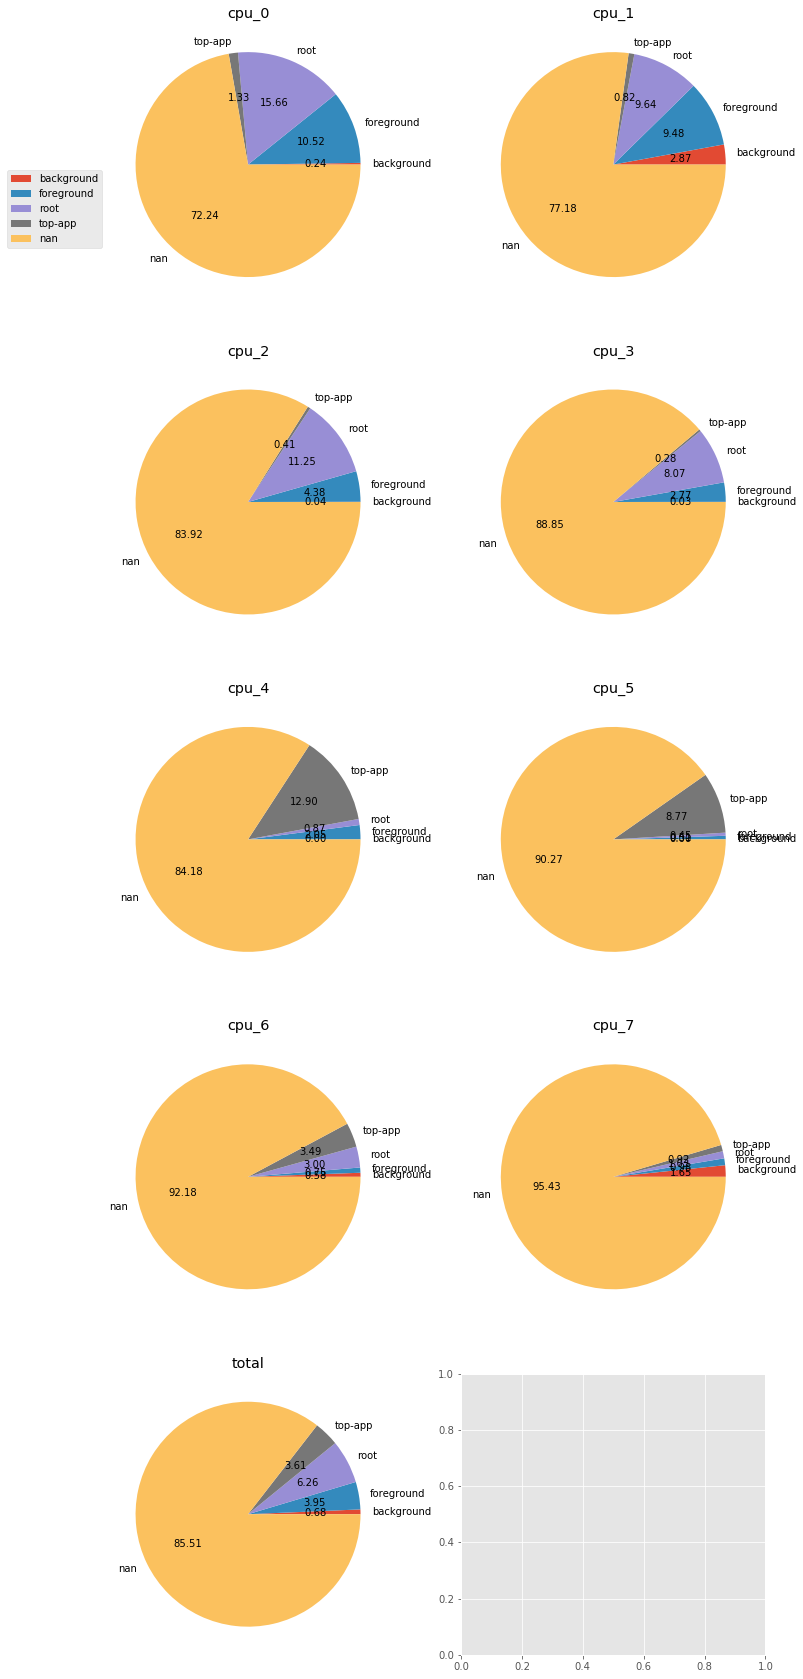

In [5]:
tr.analysis.residency.plot_cgroup('schedtune', idle=True)

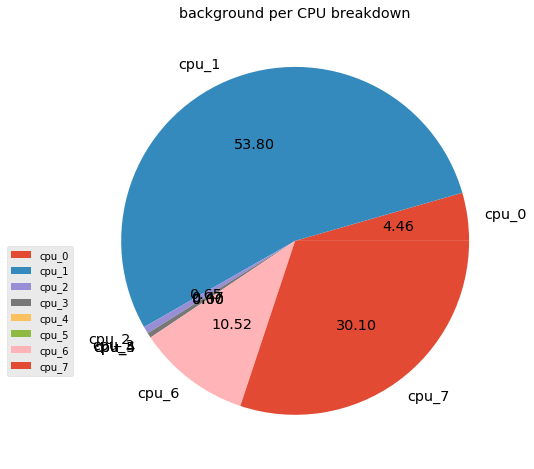

In [6]:
tr.analysis.residency.plot_cgroup('schedtune', cgroup='background')

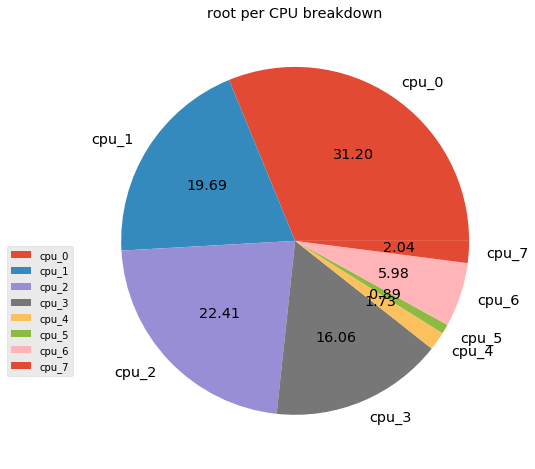

In [7]:
tr.analysis.residency.plot_cgroup('schedtune', cgroup='root')

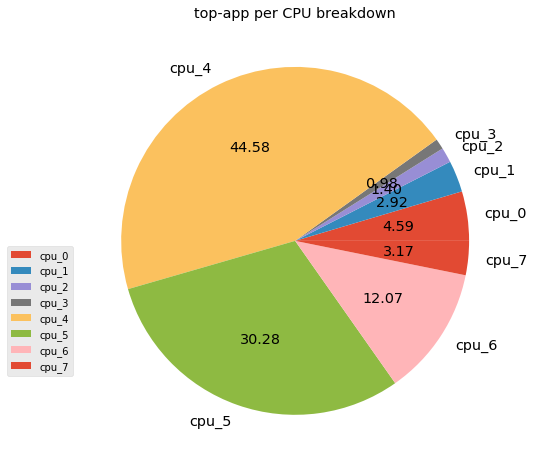

In [9]:
tr.analysis.residency.plot_cgroup('schedtune', cgroup='top-app')

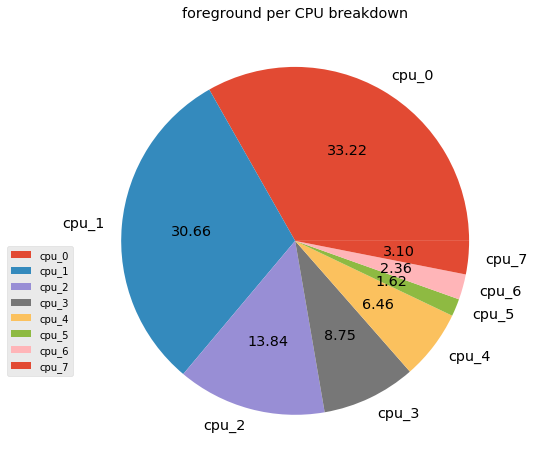

In [10]:
tr.analysis.residency.plot_cgroup('schedtune', cgroup='foreground')

Conclusions
-------------
* root CGroup ran considerably less on core 6 (7.5% to 2.6%) and slightly less on core 7 so there's definitely improvement with tasks that are not assigned to any CGroup with this patch stack
* Background group still runs on the big cores